# FUGW Barycenter

In [25]:
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/ott-jax/ott@main
    !pip install nilearn
    !pip install gdist

In [26]:
from nilearn import datasets, image, plotting, surface

import jax
import jax.numpy as jnp
import numpy as np

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from ott.problems.quadratic import gw_barycenter as gwb
from ott.solvers.quadratic import gw_barycenter as gwb_solver

In [27]:
n_subjects = 4

contrasts = [
    "sentence reading vs checkerboard",
    "sentence listening",
    "calculation vs sentences",
    "left vs right button press",
    "checkerboard",
]
cmaps = datasets.fetch_localizer_contrasts(
    contrasts,
    n_subjects=n_subjects,
).cmaps

fsaverage3 = datasets.fetch_surf_fsaverage(mesh="fsaverage4")


def load_images_and_project_to_surface(image_paths):
    """Util function for loading and projecting volumetric images."""
    images = [image.load_img(img) for img in image_paths]
    surface_images = [
        jnp.nan_to_num(surface.vol_to_surf(img, fsaverage3.pial_left))
        for img in images
    ]

    return jnp.stack(surface_images).T


def load_surfacic_contrasts(cmaps, n_subjects):
    subject_list = [f"S0{i}" for i in range(n_subjects)]
    subjects_contrasts = {}

    for i, sub in enumerate(subject_list):
        image_paths = cmaps[i * len(contrasts) : (i + 1) * len(contrasts)]
        images = load_images_and_project_to_surface(image_paths)
        subjects_contrasts[sub] = images / jnp.max(images)

    return subjects_contrasts


subjects_contrasts = load_surfacic_contrasts(cmaps, n_subjects)
subjects_contrasts["S00"].shape

/Users/plbar/micromamba/envs/ottenv/lib/python3.11/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/plbar/micromamba/envs/ottenv/lib/python3.11/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/plbar/micromamba/envs/ottenv/lib/python3.11/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/plbar/micromamba/envs/ottenv/lib/python3.11/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/plbar/micromamba/envs/ottenv/lib/python3.11/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Mean of empty slice
  texture = np.nanmean(all_samples, axis=2)
/Users/plbar/micromamba/envs/ottenv/lib/python3.11/site-packages/nilearn/surface/surface.py:464: RuntimeWarning: Me

(2562, 5)

In [28]:
x, _ = surface.load_surf_mesh(fsaverage3.pial_left)
y = jnp.repeat(x[jnp.newaxis, ...], n_subjects, axis=0)
y_fused = jnp.array(list(subjects_contrasts.values()))

In [29]:
ndim = 3
ndim_f = len(contrasts)
n_points = x.shape[0]
num_per_segment = [n_points] * n_subjects

b = jnp.ones((n_subjects, n_points)) / n_points
num_per_segment = [n_points] * n_subjects

In [30]:
fused_penalty = 0.5
epsilon = 1e-2
tau_a = 0.9
tau_b = 0.9
rank = 2

prob = gwb.GWBarycenterProblem(
    y=y,
    b=b,
    # num_per_segment=num_per_segment,
    y_fused=y_fused,
    fused_penalty=fused_penalty,
    scale_cost="max_cost",
    tau_a=tau_a,
    tau_b=tau_b,
    gw_unbalanced_correction=True,
)

In [31]:
solver = jax.jit(
    gwb_solver.GromovWassersteinBarycenter(
        epsilon=epsilon, rank=rank, max_iterations=5
    ),
    static_argnames="bar_size",
)
fugw = solver(prob, bar_size=n_points)

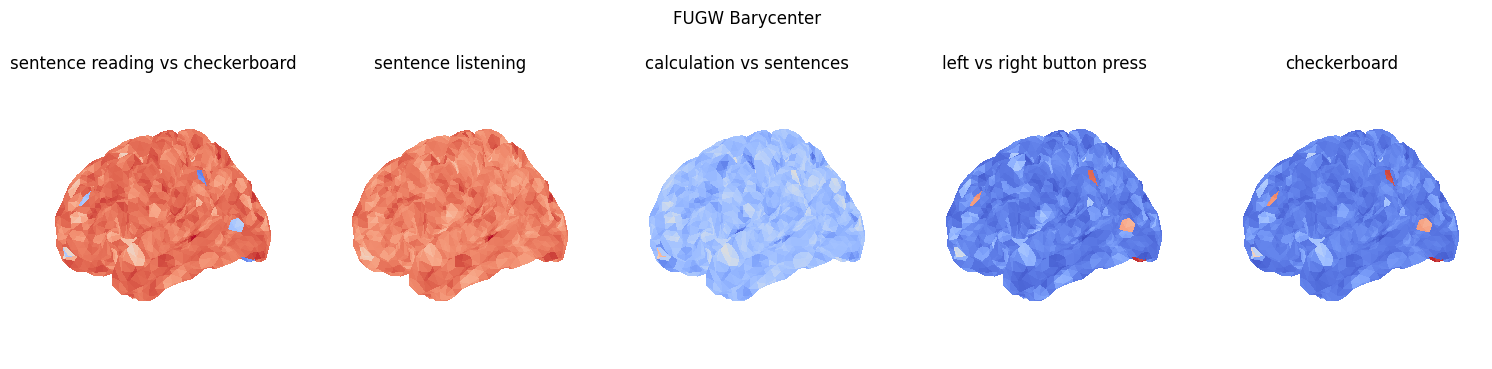

In [32]:
fig = plt.figure(figsize=(15, 4))
fig.suptitle("FUGW Barycenter")
grid_spec = gridspec.GridSpec(1, 5, figure=fig)
for i, name in enumerate(contrasts):
    ax = fig.add_subplot(grid_spec[0, i], projection="3d")
    surf_map = fugw.x[:, i]
    ax.set_title(name)
    plotting.plot_surf(
        fsaverage3.pial_left,
        np.asarray(surf_map),
        bg_map=fsaverage3.sulc_left,
        axes=ax,
        colorbar=False,
        cmap="coolwarm",
        # threshold=0.05,
    )
plt.tight_layout()